# NFS Script - Dynamic

In [1]:
import sys
sys.path.append('C:/Users/smithlab/Documents/Aaron/Modules/')
import numpy as np
from matplotlib import pyplot as plt
import VNA_control as vc
import calibration_functions as cf
import gclib
import stage_control as sc
import scipy.constants
import scipy.io
import time
import datetime

# added
import mainPyDAC2_noDelay

C     = scipy.constants.c
EPS_0 = scipy.constants.epsilon_0 #C^2/(N*m^2)
MU_0  = scipy.constants.mu_0    #m kg s^-2 A^-2
mm = 0.001
cm    = 0.01
GHz   = 1.0E9

## Scan parameters

In [2]:
xrange = 1000 # x length of stage, mm
yrange = 1000 # y length of stage, mm

fstart = 8E9
fstop = 12E9
NumFreqs = 401
NumApMasks = 1
f = np.linspace(fstart, fstop, NumFreqs)
lam_max = C/fstop
dstep = lam_max/2 * 1000 # mm

mat = scipy.io.loadmat('C:/Users/smithlab/Documents/NFS_codes/Mike_Antenna_Tuning/wrc_tuning_states.mat')
ts = mat['ts'].reshape((96, 50))

IFBW = 1000
calfile = 'Aaron_21-11-05'
power = 0
savename = 'X_Band_Horn_copol'
sParMeas = 'S12'
speedmms = 25

print('IFBW = {} \nCalibration File = {} \nPower = {} dBm \nMeasuring {}'.format(IFBW, calfile, power, sParMeas))

IFBW = 1000 
Calibration File = Aaron_21-11-05 
Power = 0 dBm 
Measuring S12


## Set scan lengths

In [3]:
Lx_ap = 130
Ly_ap = 120
theta = 60
d = 85

Lx_scan = Lx_ap + 2*d*np.tan(np.radians(theta))
Ly_scan = Ly_ap + 2*d*np.tan(np.radians(theta))

xmin = -Lx_scan/2
xmax = Lx_scan/2
ymin = -Ly_scan/2
ymax = Ly_scan/2

## Initialize instruments

In [4]:
## Stage
g = sc.stage_start('169.254.225.173')
sc.stage_home(g,speedmms)

## Arduino
# BAUDRATE, PORTNAME, #DACS
numDACs = 12
mainPyDAC2_noDelay.setSerial(115200, "COM7", numDACs)
mainPyDAC2_noDelay.sendInputLen()
msg = mainPyDAC2_noDelay.receiveFromArduino()

while msg.find("Received: " + str(numDACs) + " from serial.") == -1:
    msg = mainPyDAC2_noDelay.receiveFromArduino()
    
if not (msg == "NO VAL"):
    print(msg)


## VNA
vna = vc.instrument_open('TCPIP0::169.254.187.153::5025::SOCKET')
vc.VNA_initiate(vna, NumFreqs, fstart*1E-9, fstop*1E-9, IFBW, power, 'S12', calfile=calfile)

READY
Received: 12 from serial.
Agilent Technologies,N5222A,MY51421573,A.09.90.10
Initiating VNA...

Done



## Move to new origin

In [5]:
center_x = -xrange/2
center_y = -yrange/2
pos_x = 40  # adjust to change x zero position
pos_y = -28  # adjust to change y zero position

sc.move_to_absolute(g,speedmms,0,0,center_x+pos_x,center_y+pos_y)

(-460.0, -528.0)

## Zero axes

In [6]:
defZeroInXsteps, defZeroInYsteps = sc.zero_axes(g)

## Setup scan

In [7]:
X, Y = np.meshgrid(np.arange(xmin, xmax, dstep), np.arange(ymin, ymax, dstep), indexing='xy')
measurements = np.zeros((Y.shape[0], X.shape[1], NumFreqs, NumApMasks), dtype=np.complex128)
stops = Y.shape[0] * X.shape[1]

## Start scan

In [10]:
sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,X[0,0],Y[0,0])

(-212.2242, -207.2242)

In [11]:
t = time.time()
stopscomp = 0
# TODO edit input of tuning states
voltage_matrix_12 = [0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5,
                     0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5,
                     0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5,
                     0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5,
                     5, 5, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0,
                     5, 5, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0,
                     5, 5, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0,
                     5, 5, 4, 4, 3, 3, 2, 2, 1, 1, 0, 0]
# ts = ts[:,0]

x_list = []
y_list = []
for yn in range(Y.shape[0]):
    direction = 2*np.mod(yn+1, 2) - 1
    if direction > 0:
        xindex = np.arange(X.shape[1])
    else:
        xindex = np.flip(np.arange(X.shape[1]))
        
    for xn in xindex:
        x = X[yn, xn]
        y = Y[yn, xn]
        sc.move_to_absolute(g,speedmms,defZeroInXsteps,defZeroInYsteps,x,y)
        
        # for jj in voltage_matrix_12[0]:
        for jj in range(NumApMasks):
            mainPyDAC2_noDelay.testProgram12DAC(ts[:,jj])
            # mainPyDAC2_noDelay.testProgram12DAC(ts)
            time.sleep(0.01)
            measurements[yn,xn,:,jj] = vc.VNA_read(vna,sParMeas)
        
        stopscomp += 1
        timere = (stops - stopscomp) * (time.time()-t)/3600
        if stopscomp%10==0:
            print('Est. time remaining: {} hours'.format(timere))
        t = time.time()


['36848', '33168', '34448', '35008', '35408', '36848', '35568', '35088', '34608', '33648', '36848', '35648']
Received: 35648 from serial!
['31232', '32112', '28672', '30112', '30752', '31152', '28672', '31632', '31152', '30592', '29792', '32752']
Received: 32752 from serial!
['26256', '26976', '27456', '28656', '25776', '26576', '25936', '24576', '27696', '27056', '26656', '25936']
Received: 25936 from serial!
['20560', '22080', '22720', '23120', '24560', '21120', '22720', '22240', '21120', '24560', '23200', '22720']
Received: 22720 from serial!
['18624', '19104', '20464', '17024', '18144', '18624', '17424', '20464', '19104', '18704', '18064', '16864']
Received: 16864 from serial!
['13648', '14368', '14768', '15408', '12288', '13728', '14368', '13648', '16368', '15248', '14688', '14048']
Received: 14048 from serial!
['12272', '9232', '10112', '10592', '11152', '12272', '10672', '10272', '9632', '8192', '11632', '10752']
Received: 10752 from serial!
['6816', '8176', '4576', '5856', '633

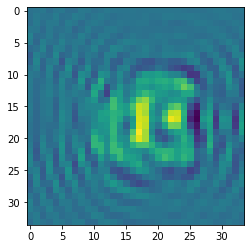

In [21]:
plt.imshow(np.real(measurements[:,:,200,0]))
plt.show()

## Save data

In [15]:
savepath = 'C:/Users/smithlab/Documents/Near_Field_Scans/'
scipy.io.savemat('{}{}_{}.mat'.format(savepath, savename, datetime.datetime.now().strftime('%Y-%m-%d')),
                                      {'X': X,
                                       'Y': Y,
                                       'f': f,
                                       'measurements': measurements})

## Clean up communications

In [5]:
sc.close_connection(g)
vna.close()

NameError: name 'g' is not defined